# Initialisation du projet

In [1]:
# bibliotheques mathematiques
import numpy as np

# bibliotheques pour les representations graphiques
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats

# bibliotheques pour le machine learning
import sklearn.decomposition
import sklearn.svm
import sklearn.neighbors
from sklearn.preprocessing import normalize
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# bibliotheque pour les modèles
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

# bibliotheques pour le chargement des donnees
import csv
import pandas as pd

plt.ion()

In [2]:
def load_sub_sets(ratio_train, ratio_valid, train_csv, test_csv):
    data_train = np.genfromtxt(train_csv, delimiter=",", skip_header=1) # lecture du fichier train_csv
    y = data_train[:,0]                                                 # les labels
    X = data_train[:,1:]                                                # les donnees (sans leurs labels)
    
    Ntot   = X.shape[0]                                                 # nombre d'images dans les donnees X
    Ntrain = int(ratio_train*Ntot)                                      # nombre d'images pour l'entrainement
    Nvalid = int(ratio_valid*Ntot)                                      # nombre d'images pour la validation
    
    X_train = X[0: Ntrain].copy()                                       # les donnees qu'on utilise pour entrainer les modeles
    y_train = y[0: Ntrain].copy()                                       # les labels associes 
    
    X_valid = X[Ntrain:Ntrain+Nvalid].copy()                            # les donnees qu'on utilise pour tester les modeles
    y_valid = y[Ntrain:Ntrain+Nvalid].copy()                            # les labels associes
        
    data_test = np.genfromtxt(test_csv, delimiter=",", skip_header=1)   # lecture du fichier test_csv
    data_test = data_test[1:]                                           # donnees generales du fichier test_csv (celles que le modele ne connait pas)
    X_test  = data_test[:,1:]                                           # les labels
    y_test  = data_test[:,0]                                            # les donnees (sans leur label)
    
    return X, y, X_train, y_train, X_valid, y_valid, X_test, y_test

In [3]:
dim_repre = 28
ratio_train = 0.7
ratio_valid = 0.3

X, y, X_train, y_train, X_valid, y_valid, X_test, y_test = load_sub_sets(ratio_train, ratio_valid, "sign_mnist_train.csv", "sign_mnist_test.csv")

---
# Exploration des données

On affiche quelques données du dataset sous la forme d'images

In [4]:
nb_alphabet_letters = 26

def get_letter_at_idx(idx):
    return chr(ord("A") + idx)

## 1. Représentation de différentes données

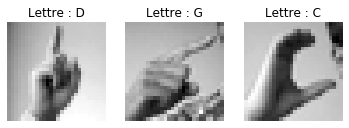

In [5]:
nb_displayed_dataset = 3
fig, ax = plt.subplots(1, nb_displayed_dataset)                         # creation de 3 subplots horizontaux

for i in range(nb_displayed_dataset):
    label_idx = int(y[i])                                               # on récupère l'indice alphabetique lié à la donnée
    letter_rep = chr(ord("A") + label_idx)                              # on transforme l'indice en lettre (eg. indice 0 devient 'A')
    ax[i].set_axis_off()                                                # on cache les axes
    ax[i].set_title(f"Lettre : {letter_rep}")                           # on affiche la lettre dans le titre
    ax[i].imshow(X[i].reshape(dim_repre, dim_repre), cm.gray)           # on affiche l'image sous la forme de nuance de gris en
                                                                        #  transformant la matrice linéaire en matrice carré

## 2. Différentes représentations d'un même label

In [6]:
selected_label_idx = 0                                                  # on choisi d'afficher différentes représentations d'une lettre
selected_letter = chr(ord("A") + selected_label_idx)                    # la lettre selectionnée
only_A = (selected_label_idx == y)                                      # on créé un mask qui filtre les données qui représente notre lettre sélectionnée
X_of_A = X[only_A]                                                      # on applique notre masque
print(f"Nous avons trouvés {X_of_A.shape[0]} représentations de la lettre {selected_letter}.")

Nous avons trouvés 1126 représentations de la lettre A.


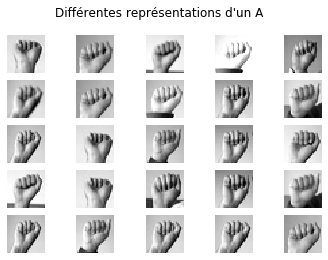

In [7]:
nb_subplots_by_ax = 5
fig, ax = plt.subplots(nb_subplots_by_ax, nb_subplots_by_ax)            # creation des subplots

fig.suptitle(f"Différentes représentations d'un {selected_letter}")
for i in range(nb_subplots_by_ax):
    for j in range(nb_subplots_by_ax):
        idx = i*nb_subplots_by_ax + j                                   # on transforme le couple (i,j) en l'indice de l'image
        img = X_of_A[idx].reshape(dim_repre, dim_repre)                 # transformation de la matrice linéaire en matrice carré
        ax[i,j].set_axis_off()                                          # on cache les axes
        ax[i,j].imshow(img, cm.gray)                                    # on affiche l'image sous la forme de nuance de gris

## 3. Analyse du dataset

In [8]:
print("Description des données :")

df = pd.DataFrame(X)
df.describe()

Description des données :


,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,165.533673,...,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,31.279244,...,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,148.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,125.500000
50%,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,167.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,182.000000
75%,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,186.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,204.000000,204.000000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [9]:
print("Description des labels :")

df = pd.DataFrame(y, columns=["labels"])
df.describe()

Description des labels :


,labels
count,27455.000000
mean,12.318813
std,7.287552
min,0.000000
25%,6.000000
50%,13.000000
75%,19.000000
max,24.000000


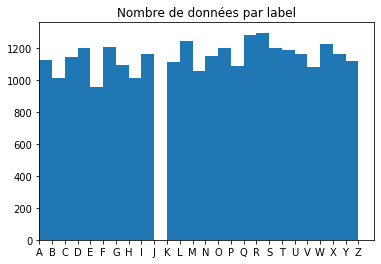


Il manque les lettres : J, Z


In [10]:
xticks_labels = [get_letter_at_idx(i) for i in range(nb_alphabet_letters)]

fig, ax = plt.subplots(1, 1)
hist, _, _ = ax.hist(y, bins=range(nb_alphabet_letters))
ax.set_xticks(range(nb_alphabet_letters))
ax.set_title("Nombre de données par label")
ax.set_xticklabels(xticks_labels)
ax.set_xlim(0)
plt.show()

h = hist.copy()
h.resize(nb_alphabet_letters)
missing_indexes = [arg[0] for arg in np.argwhere(h == 0.)]
print(f"\nIl manque les lettres : {', '.join(map(get_letter_at_idx, missing_indexes))}")

## 4. Affichage des images moyennes

In [11]:
def display_mean_image(X, y):
    nb_rows = 5
    nb_cols = 5
    fig, ax = plt.subplots(nb_rows, nb_cols, figsize=(8,8))

    fig.subplots_adjust(hspace=.3)
    fig.suptitle(f"Représentations moyenne des différentes lettres")

    for i in range(nb_rows):
        for j in range(nb_cols):
            idx = i * nb_rows + j
            if idx > nb_alphabet_letters:
                break
            ax[i,j].set_axis_off()
            ax[i,j].set_title(get_letter_at_idx(idx))
            if idx in missing_indexes:
                continue
            only_of_letter = (idx == y)                                     # on créé un mask qui filtre les données qui représente notre lettre sélectionnée
            X_of_letter = X[only_of_letter]                                 # on applique notre masque
            mean_X_of_letter = np.mean(X_of_letter, axis=0)
            mean_img = mean_X_of_letter.reshape((dim_repre, dim_repre))
            ax[i,j].imshow(mean_img, cm.gray)

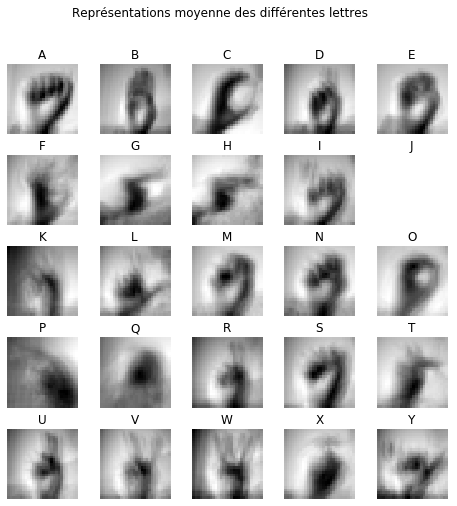

In [12]:
display_mean_image(X, y)

# Filtrage des doublons

In [13]:
def show_duplicated(data, duplicated, n_rows=3, n_max_cols=5):
    fig, ax = plt.subplots(n_rows, n_max_cols+1)

    fig.suptitle("Affichage des images dupliqués")
    duplicated = list(filter(lambda x: len(x[1]) == n_max_cols, duplicated))

    for i, (img_idx, others) in enumerate(duplicated[:n_rows]):
        img = data[img_idx]
        ax[i, 0].imshow(img.reshape(dim_repre, dim_repre), cm.gray)
        ax[i, 0].set_axis_off()                                         # on cache les axes
        if i == 0: ax[i, 0].set_title("originale")                      # on affiche la lettre dans le titre
        for j, dup_img_idx in enumerate(others):
            dup_img = data[dup_img_idx]
            ax[i, j+1].imshow(dup_img.reshape(dim_repre, dim_repre), cm.gray)
            ax[i, j+1].set_axis_off()                                   # on cache les axes
            if i == 0: ax[i, j+1].set_title(f"{j+1}")                   # on affiche la lettre dans le titre

# from @abakar https://stackoverflow.com/a/60223949
def remove_values_with_corr_sup(data, corr_bound):
    def get_duplicated_data(corr_upper, col):
        mask = (corr_upper[col] > corr_bound).to_numpy()
        return [args[0] for args in np.argwhere(mask == True)]
    df = pd.DataFrame(data).transpose()
    corr_matrix = df.corr().abs()
    triu_ones = np.triu(np.ones(corr_matrix.shape), k=1)
    corr_upper = corr_matrix.where(triu_ones.astype(np.bool))
    to_drop = [col for col in corr_upper.columns if any(corr_upper[col] > corr_bound)]
    duplicated = [(col, get_duplicated_data(corr_upper, col)) for col in to_drop]
    df = df.drop(df[to_drop], axis=1)
    data = df.transpose().to_numpy()
    return data, duplicated, to_drop

In [14]:
corr_threshold = .99

print("Suppression des doublons dans les données de validation ...")
X_valid_bis, X_valid_dup, X_valid_dropped = remove_values_with_corr_sup(X_valid, corr_threshold)
y_valid_bis = np.delete(y_valid, X_valid_dropped)
print("Suppression des doublons dans les données de test ...")
X_test_bis, X_test_dup, X_test_dropped = remove_values_with_corr_sup(X_test, corr_threshold)
y_test_bis = np.delete(y_test, X_test_dropped)

Suppression des doublons dans les données de validation ...


KeyboardInterrupt: 

In [ ]:
show_duplicated(X_valid, X_valid_dup)

In [ ]:
fig, ax = plt.subplots(1, 2)

fig.subplots_adjust(wspace=.3)

ax[0].set_title("Données de validation")
ax[0].bar(["Avant", "Après"], [X_valid.shape[0], X_valid_bis.shape[0]], width=1)
ax[0].set_ylabel("nombre de données")

ax[1].set_title("Données de test")
ax[1].bar(["Avant", "Après"], [X_test.shape[0], X_test_bis.shape[0]], width=1)

plt.show()

---

# Préprocessing
Sélection du meilleur nombre de composants

In [ ]:
class CompRanker:
    def __init__(self, n):
        self.n_comps_score = [0 for i in range(n)]
        
    def update_rank(self, data, reverse=False):
        for i, x in enumerate(data):
            self.n_comps_score[i] += -x if reverse else x

    def get_best_n_comps(self, nb_comp_range):
        scores = sorted(enumerate(self.n_comps_score), key=lambda x: x[1], reverse=True)
        formated_ranks = [(nb_comp_range[i], score) for i, score in scores]
        return tuple(zip(*formated_ranks))

In [ ]:
def get_scores_for_nb_comp_range(nb_comp_range):
    training_scores = []                                                # tableau des scores d'entrainement en fonction du nombre de composants séléctionné
    valid_scores = []                                                   # tableau des scores de validation en fonction du nombre de composants séléctionné
    explained_variances = []                                            # tableau des scores de validation en fonction du nombre de composants séléctionné
    tab_result = pd.DataFrame(columns=[
        "score d\'entrainement",
        "score de validation",
        "différence"])                                                  # tableau récapitulatif

    for nb_comp in nb_comp_range:
        print(f"Récupération du score pour une PCA de {nb_comp} composants...")
        pre_proc = sklearn.decomposition.PCA(n_components=nb_comp)      # création d'un PCA permettant la compression des images en nb_comp pixels
        pre_proc.fit(X)                                                 # entrainement du modèle PCA
        X_train_transformed = pre_proc.transform(X_train)               # transformation des données d'entrainement en fonction du PCA
        X_valid_transformed = pre_proc.transform(X_valid)               # transformation des données de validation en fonction du PCA

        clf = sklearn.svm.SVC(kernel="poly", coef0=1, degree=2)         # on choisit un classifieur SVC
        clf.fit(X_train_transformed, y_train)                           # on entraine notre classifieur avec X_train_transformed

        train_score = clf.score(X_train_transformed, y_train)           # on récupère les scores liés (entrainement)
        valid_score = clf.score(X_valid_transformed, y_valid)           # on récupère les scores liés (validation)

        tab_result.loc[f"{nb_comp} composants"] = np.array([
            f"{train_score * 100:.2f}%",
            f"{valid_score * 100:.2f}%",
            f"{(train_score-valid_score) * 100:.2f}%"])                 # ajout des données dans le tableau récapitulatif (en pourcentage)

        training_scores.append(train_score * 100)                       # on sauvegarde les scores d'entrainement pour les statistiques
        valid_scores.append(valid_score * 100)                          # on sauvegarde les scores de validation pour les statistiques
        explained_variances.append(sum(pre_proc.explained_variance_ratio_) * 100)

    return np.array(training_scores), np.array(valid_scores), explained_variances, tab_result

In [ ]:
def plot_best_explained_variance(comp_ranker, nb_comp_range, explained_variances):
    plt.title("Évolution de la variance expliquée\nen fonction du nombre de composants")
    plt.plot(nb_comp_range, explained_variances)
    plt.xlabel("nombre de composants")
    plt.ylabel("variance expliquée (%)")

    best_index = np.argmax(explained_variances)
    best_n_comp = nb_comp_range[best_index]
    plt.plot(best_n_comp, explained_variances[best_index], marker="X", color="red")

    print(f"Meilleur nombre de composants pour maximiser la variance expliqué : {best_n_comp}\n")
    comp_ranker.update_rank(explained_variances)

In [ ]:
def plot_best_scores(comp_ranker, nb_comp_range, training_scores, valid_scores):
    plt.title("Évolution du score en fonction du nombre de composants")
    plt.plot(nb_comp_range, training_scores, label="train score")
    plt.plot(nb_comp_range, valid_scores, label="valid score")
    plt.xlabel("nombre de composants")
    plt.ylabel("scores (%)")
    plt.legend()

    best_index = np.argmax(training_scores)
    best_n_comp = nb_comp_range[best_index]
    plt.plot(best_n_comp, training_scores[best_index], marker="X", color="red")

    print(f"Meilleur nombre de composants pour maximiser le score : {best_n_comp}\n")
    comp_ranker.update_rank(training_scores)

In [ ]:
def plot_less_overfitting(comp_ranker, nb_comp_range, training_scores, valid_scores):
    diff_scores = training_scores - valid_scores

    plt.title("Évolution de l'overfitting en fonction du nombre de composants")
    plt.plot(nb_comp_range, diff_scores)
    plt.xlabel("nombre de composants")
    plt.ylabel("différence (%)")

    best_index = np.argmin(diff_scores)
    best_n_comp = nb_comp_range[best_index]
    plt.plot(best_n_comp, diff_scores[best_index], marker="X", color="red")

    print(f"Meilleur nombre de composants pour minimiser l'overfitting : {best_n_comp}\n")

    comp_ranker.update_rank(diff_scores, reverse=True)

In [ ]:
def plot_best_incr_scores(comp_ranker, nb_comp_range, training_scores, valid_scores):
    training_scores_incr = np.array([
        score - training_scores[i-1] if i != 0 else 0
        for i, score in enumerate(training_scores)])
    valid_scores_incr = np.array([
        score - valid_scores[i-1] if i != 0 else 0
        for i, score in enumerate(valid_scores)])

    plt.title("Évolution de l'accroissement du score en fonction du nombre de composants")
    plt.plot(nb_comp_range, training_scores_incr, label="train score")
    plt.plot(nb_comp_range, valid_scores_incr, label="valid score")
    plt.xlabel("nombre de composants")
    plt.ylabel("accroissement du score (%)")
    plt.legend()

    best_index = np.argmax(training_scores_incr)
    best_n_comp = nb_comp_range[best_index]
    plt.plot(best_n_comp, training_scores_incr[best_index], marker="X", color="red")

    print(f"Meilleur nombre de composants pour maximiser le gain de score : {best_n_comp}\n")

    comp_ranker.update_rank(valid_scores_incr)

In [ ]:
def get_best_np_comp(comp_ranker, nb_comp_range):
    x_nb_comp, y_score = comp_ranker.get_best_n_comps(nb_comp_range)

    plt.title("Évaluation du meilleur nombre de composants\nen fonction du score moyen")
    plt.bar(x_nb_comp, y_score, width=1)
    plt.xlabel("nombre de composants")
    plt.ylabel("score moyen")

    best_nb_comp, best_score = -1, -1
    for nb_comp, score in zip(x_nb_comp, y_score):
        if score > best_score:
            best_nb_comp = nb_comp
            best_score = score

    plt.plot(best_nb_comp, best_score, marker="X", color="red")
    print(f"Meilleur nombre de composants : {best_nb_comp}\n")

    return best_nb_comp    

## 1. Première sélection (sélection large)

In [ ]:
s1_nb_steps = 5
s1_incr = 10
s1_min = 1
s1_max = s1_min + s1_nb_steps * s1_incr
s1_nb_comp_range = np.arange(s1_min, s1_max, s1_incr)

In [ ]:
s1_training_scores, s1_valid_scores, s1_explained_variances, s1_tab = get_scores_for_nb_comp_range(s1_nb_comp_range)

In [ ]:
s1_n = len(s1_training_scores)
s1_comp_ranker = CompRanker(s1_n)
s1_tab

In [ ]:
plot_best_explained_variance(s1_comp_ranker, s1_nb_comp_range, s1_explained_variances)

In [ ]:
plot_best_scores(s1_comp_ranker, s1_nb_comp_range, s1_training_scores, s1_valid_scores)

In [ ]:
plot_less_overfitting(s1_comp_ranker, s1_nb_comp_range, s1_training_scores, s1_valid_scores)

In [ ]:
plot_best_incr_scores(s1_comp_ranker, s1_nb_comp_range, s1_training_scores, s1_valid_scores)

In [ ]:
s1_best_nb_comp = get_best_np_comp(s1_comp_ranker, s1_nb_comp_range)

## 2. Deuxième sélection (sélection moyenne)

In [ ]:
s2_nb_steps = 5
s2_incr = 3
s2_min = s1_best_nb_comp - int(s2_nb_steps/2)     * s2_incr
s2_max = s1_best_nb_comp + (1+int(s2_nb_steps/2)) * s2_incr
s2_nb_comp_range = np.arange(s2_min, s2_max, s2_incr)

In [ ]:
s2_training_scores, s2_valid_scores, s2_explained_variances, s2_tab = get_scores_for_nb_comp_range(s2_nb_comp_range)

In [ ]:
s2_n = len(s2_training_scores)
s2_comp_ranker = CompRanker(s2_n)
s2_tab

In [ ]:
plot_best_explained_variance(s2_comp_ranker, s2_nb_comp_range, s2_explained_variances)

In [ ]:
plot_best_scores(s2_comp_ranker, s2_nb_comp_range, s2_training_scores, s2_valid_scores)

In [ ]:
plot_less_overfitting(s2_comp_ranker, s2_nb_comp_range, s2_training_scores, s2_valid_scores)

In [ ]:
plot_best_incr_scores(s2_comp_ranker, s2_nb_comp_range, s2_training_scores, s2_valid_scores)

In [ ]:
s2_best_nb_comp = get_best_np_comp(s2_comp_ranker, s2_nb_comp_range)

## 3. Troisième sélection (sélection étroite)

In [ ]:
s3_nb_steps = 5
s3_incr = 1
s3_min = s2_best_nb_comp - int(s3_nb_steps/2)     * s3_incr
s3_max = s2_best_nb_comp + (1+int(s3_nb_steps/2)) * s3_incr
s3_nb_comp_range = np.arange(s3_min, s3_max, s3_incr)

In [ ]:
s3_training_scores, s3_valid_scores, s3_explained_variances, s3_tab = get_scores_for_nb_comp_range(s3_nb_comp_range)

In [ ]:
s3_n = len(s3_training_scores)
s3_comp_ranker = CompRanker(s3_n)
s3_tab

In [ ]:
plot_best_explained_variance(s3_comp_ranker, s3_nb_comp_range, s3_explained_variances)

In [ ]:
plot_best_scores(s3_comp_ranker, s3_nb_comp_range, s3_training_scores, s3_valid_scores)

In [ ]:
plot_less_overfitting(s3_comp_ranker, s3_nb_comp_range, s3_training_scores, s3_valid_scores)

In [ ]:
plot_best_incr_scores(s3_comp_ranker, s3_nb_comp_range, s3_training_scores, s3_valid_scores)

In [ ]:
s3_best_nb_comp = get_best_np_comp(s3_comp_ranker, s3_nb_comp_range)

## 4. Conclusion

In [ ]:
best_nb_comp = s3_best_nb_comp
pre_proc = sklearn.decomposition.PCA(n_components=best_nb_comp)
pre_proc.fit(X)

X_train_transformed = pre_proc.transform(X_train)
X_valid_transformed = pre_proc.transform(X_valid)
X_test_transformed = pre_proc.transform(X_test)

print(f"Le meilleur nombre de composant pour la PCA : {best_nb_comp}")

In [ ]:
nb_pictures = 3
fig, ax = plt.subplots(2, nb_pictures)

fig.suptitle(f"Affichage des images compressé par la PCA")

for i in range(nb_pictures):
    img = X_train[i].reshape(dim_repre, dim_repre)
    inverse_transformed_img = pre_proc.inverse_transform(X_train_transformed[i])
    compressed_img = inverse_transformed_img.reshape(dim_repre, dim_repre)
    if i == 0:
        ax[0,i].set_ylabel("originales")
        ax[1,i].set_ylabel("compressées")
    ax[0,i].set_xticks([])
    ax[1,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_yticks([])
    ax[0,i].imshow(img, cm.gray)
    ax[1,i].imshow(compressed_img, cm.gray)

---

# Modèle
## Sélection du meilleur modèle

In [ ]:
model_dict = dict(SVC=SVC(),                                            # On créé un dictionnaire de modèle
                  NuSVC=NuSVC(),
                  DecisionTree=DecisionTreeClassifier(),
                  LinearSVC=LinearSVC())

In [ ]:
def comparison_of_models(X_train, y_train, X_valid, y_valid, model_dict):
    tab_result = pd.DataFrame(columns=["CVScore",                       # On créé un tableau panda
                                       "(+/-)",
                                       "Score_training",
                                       "Score_validation"])  
    for model_name, model in model_dict.items():                        # On itère sur chaque modèle du dictionnaire
        print("Calcul des scores pour le modèle", model_name, "...")
        print("\t- Entrainement du modèle avec l'ensemble d'entrainement")
        if model_name == "LinearSVC":
            model.fit(normalize(X_train), y_train)
        else:
            model.fit(X_train, y_train)                                 # On entraine le modèle sur l'ensemble d'entrainement
        print("\t- Calcul du score de validation croisée")
        CVScore = cross_val_score(model, X_train, y_train, cv=5)        # On calcul la cross validation
        print("\t- Calcul du score sur l'ensemble d'entrainement")
        train_score = model.score(X_train, y_train)                     # On calcul le score sur l'ensemble d'entrainement
        print("\t- Calcul du score sur l'ensemble de validation")
        valid_score = model.score(X_valid, y_valid)                     # On calcul le score sur l'ensemble de validation
        print("... Fin des calculs pour le modèle", model_name)
        tab_result.loc[model_name] = np.array([CVScore.mean(),          # On ajoute les scores dans le tableau
                                               CVScore.std(),
                                               train_score,
                                               valid_score])
    return tab_result

### comparaison avec PCA

In [ ]:
compar_results_with_PCA = comparison_of_models(X_train_transformed,     # Appel de la fonction "performance" avec nos données transformées
                                               y_train,
                                               X_valid_transformed,
                                               y_valid,
                                               model_dict)

In [ ]:
best_model_with_PCA = compar_results_with_PCA.Score_validation.idxmax()
print("Le meilleur modèle avec la PCA est : {}".format(best_model_with_PCA))
compar_results_with_PCA.round(6)                                        # On affiche le tableau résultant

### comparaison sans PCA

In [ ]:
compar_results_without_PCA = comparison_of_models(X_train,              # Appel de la fonction "performance" avec les données initiales
                                      y_train,
                                      X_valid,
                                      y_valid,
                                      model_dict)

In [ ]:
best_model_without_PCA = compar_results_without_PCA.Score_validation.idxmax()
print("Le meilleur modèle sans PCA est : {}".format(best_model_without_PCA))
compar_results_without_PCA.round(6)                                      # On affiche le tableau résultant

## Sélection des hyper-paramètres

In [ ]:
model = SVC(kernel='poly')                                               # On initialise notre meilleur modèle
hyper_parameters = dict(C=[1, 3],
                        degree=[2, 3, 4],                                # On créé un dictionnaire d'hyper-paramètres de ce modèle
                        coef0=[0.0, 1.0, 2.0])
model_select = GridSearchCV(svc, distributions, cv=5)                    # On apelle la fonction GridSearchCV
model_select.fit(X_train_transformed, y_train)                           # On entraine notre modèle avec toutes les combinaisons des hyper-paramètres possible et en calculant la cross-validation

In [ ]:
print("Les différentes configurations possibles dans la recherche des hyper-paramètres")
for i, v in enumerate(model_select.cv_results_["params"]):               # On affiche les différentes configurations possible
    print(f"configuration {i}: {v}")

In [ ]:
scores = model_select.cv_results_["mean_test_score"]
configuration = list(range(len(model_select.cv_results_["params"])))
plt.title('Évolution du score en fonction des hyper-paramètres')
plt.plot(configuration, scores, label='train score')
plt.plot(np.argmax(scores), max(scores), marker='X', color='red')
plt.xlabel('configuration des hyper-paramètres')
plt.ylabel("score de l'ensemble d'entrainement")
plt.legend()

In [ ]:
print(f"La meilleure configuration du modèle est : {model_select.best_estimator_}")

---

# Test final

In [ ]:
display_mean_image(X_test, y_test)

In [ ]:
X_transformed = pre_proc.transform(X)

svc = model_select.best_estimator_
svc.fit(X_transformed, y)
print("Score final sur l'ensemble test : ", svc.score(X_test_transformed, y_test))